## Customer Support Bot

In [27]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_KEY')

In [28]:
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "ChatBot"

In [29]:
from langchain.chat_models import init_chat_model

model = init_chat_model("llama3-8b-8192", model_provider="groq")

In [30]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

In [31]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [32]:
llm = model

In [33]:
def categorize(state: State):
    prompt = ChatPromptTemplate.from_template("Categorize the query into one of the following categories: Technical, Billing and General. Here's the query: {query}")
    chain = prompt | llm
    category = chain.invoke({"query": state["query"]}).content
    print("Category: ", {category})
    return {"category": category}

def analyze_sentiment(state: State):
    prompt = ChatPromptTemplate.from_template("Analyze the response of the customer query and answer in one word i.e. either positive, negative or neutral. The query is: {query}")
    chain = prompt | llm
    sentiment = chain.invoke({"query": state["query"]}).content
    print("sentiment: ", {sentiment})
    return {"sentiment": sentiment}

def handle_technical(state: State):
    prompt = ChatPromptTemplate.from_template("Provide a technical support response to the following query: {query}")
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    print("response: ", {response})
    return {"response": response}

def handle_billing(state: State):
    prompt = ChatPromptTemplate.from_template("Provide a billing support response to the following query: {query}")
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    print("response: ", {response})
    return {"response": response}

def handle_general(state: State):
    prompt = ChatPromptTemplate.from_template("Provide a general support response to the following query: {query}")
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    print("response: ", {response})
    return {"response": response}

def escalate(state: State):
    return {"response": "This query has been forwarded to human agent due to negative sentiment."}

def route_query(state: State):
    if state["sentiment"] == "negative":
        return "escalate"
    elif state["category"] == "technical":
        return "handle_technical"
    elif state["category"] == "billing":
        return "handle_billing"
    else:
        return "handle_general"

In [34]:
workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# flow: categorize → analyze_sentiment → conditional handlers
workflow.add_edge("categorize", "analyze_sentiment")

workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate",
    },
)

# handlers all end
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")

app = workflow.compile()


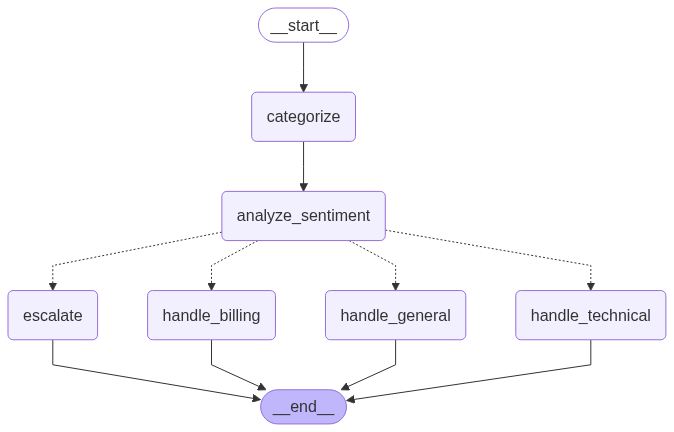

In [35]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
def run_customer_support(query:str):
    results = app.invoke({"query": query})
    return {
        "category": results['category'],
        "sentiment": results["sentiment"],
        "response" : results["response"]
    }

In [37]:
query = "The price value in my bill is wrong!"
results = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {results['category']}")
print(f"Sentiment: {results['sentiment']}")
print(f"Response: {results['response']}")


Category:  {'I would categorize this query as "Billing".'}
sentiment:  {'Negative'}
response:  {"I'm so sorry to hear that the price value in your bill is incorrect. Can you please provide me with more details about the issue you're experiencing? Here are a few questions to help me better understand the situation:\n\n* What is the correct price you were expecting to see on the bill?\n* What is the incorrect price that is showing on the bill?\n* Is this a one-time error or has this happened consistently with your orders?\n* Have you received any discounts or promotions that may be affecting the price?\n\nOnce I have this information, I'll do my best to assist you in resolving the issue as quickly and efficiently as possible."}
Query: The price value in my bill is wrong!
Category: I would categorize this query as "Billing".
Sentiment: Negative
Response: I'm so sorry to hear that the price value in your bill is incorrect. Can you please provide me with more details about the issue you're 

## Chat Bot

In [38]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [39]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [40]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

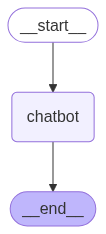

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [42]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


## Memory

In [43]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [44]:
graph = graph_builder.compile(checkpointer=memory)

In [45]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config = {"configurable": {"thread_id": "1"}}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


## Enhancing the chatbot with tools

In [46]:
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

In [47]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-maki

## ChatBot with Memory and Tool

In [49]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

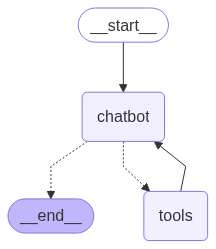

In [50]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [51]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config = {"configurable": {"thread_id": "1"}}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://finance.yahoo.com/news/space-open-business-even-rogers-214500752.html", "title": "Space is open for business with Even Rogers and Max Haot at TechCrunch Disrupt 2025 - Yahoo Finance", "score": 0.46482924, "published_date": "Wed, 20 Aug 2025 22:43:01 GMT", "content": "9.   Breaking News • 12 hours ago Michael Fiddelke is Target's first new CEO since 2014. Here are his challenges.\n    10.   News • 23 hours ago Intel is getting a $2 billion lifeline from SoftBank and could get more from Trump. But that may not be enough.\n    11.   News • yesterday Bitcoin is barreling toward $200,000, analysts say. Here's why.\n    12.   News • yesterday Palantir just extended its losing streak to 5 trading days. The slide reflects waning investor interest in Big Tech. [...] 31.   News • 4 days ago Nvidia's high-stakes earnings are just around the corner. Could Trump's 